[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1358
[LightGBM] [Info] Number of data points in the train set: 152400, number of used features: 19
[LightGBM] [Info] Start training from score -2.440249
[LightGBM] [Info] Start training from score -2.472465
[LightGBM] [Info] Start training from score -0.188157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


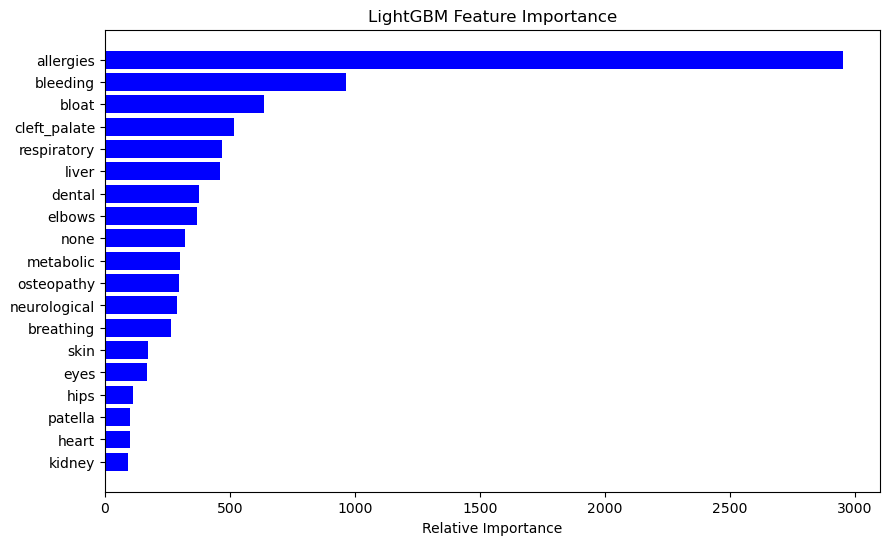

AILMENTS DATASET
Accuracy Score: 0.9201837270341208
Classification Report:
               precision    recall  f1-score   support

           2       0.68      0.80      0.73      3366
           3       0.85      0.63      0.72      3275
           4       0.96      0.96      0.96     31459

    accuracy                           0.92     38100
   macro avg       0.83      0.80      0.81     38100
weighted avg       0.92      0.92      0.92     38100

Confusion Matrix:
 [[ 2678     0   688]
 [  492  2068   715]
 [  776   370 30313]]
Model Accuracy: 92.02%


In [77]:

# Import the necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import lightgbm as lgb


# Load the CSV files
df = pd.read_csv('nobreed_data.csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.fillna(0).astype(int)

# ------------ AILMENTS TESTING ----------------

# Drop behaviour related columns 
ailments = df.drop(columns=['size','age','longevity', 'gender','intelligence_category', 'sensitivity_level', 
                            'tolerates_being_alone', 'grooming_required','tolerates_hot_weather', 'tolerates_cold_weather',
                           'kid_friendly', 'category_companion', 'category_herding', 'category_hound',
                               'category_sporting', 'category_terrier', 'category_working',
                           'dog_friendly', 'stranger_friendly', 'potential_for_mouthiness',
                           'prey_drive', 'tendency_to_bark_or_howl', 'wanderlust_potential',
                           'exercise_needs', 'energy_level' ], axis=1)

# Split the dataset into variables and target feature
X = ailments.drop('yearly_final_cost', axis=1)
y = ailments['yearly_final_cost']

# Define bins and labels for binning the target feature
bins = [2025, 2500, 2900, 3300, 3580, np.inf]
labels = ['lowest', 'low', 'medium', 'high', 'highest']
y_binned = pd.cut(y, bins=bins, labels=labels)

# Encode the labels into numerical values
encoder = LabelEncoder()
y_encoded = y_binned.cat.codes

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.2, random_state=123)

# Apply light gradient machine boosting, to analyze feature importance.
lightgbm_model = lgb.LGBMClassifier(n_estimators=100, random_state=123)
lightgbm_model.fit(X_train, y_train)

def plot_feature_importances(importances, feature_names, title):
    indices = np.argsort(importances)
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

plot_feature_importances(lightgbm_model.feature_importances_, X.columns, 'LightGBM Feature Importance')
# Train the model
knn = KNeighborsClassifier(n_neighbors=7, metric='minkowski')
knn.fit(X_train_scaled, y_train)

# Make predictions
y_pred = knn.predict(X_test_scaled)


# Model evaluation
print("AILMENTS DATASET")
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Model Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

